In [47]:
import sys
sys.path.append('../code')
import FOT

import math
import numpy as np
import random
import ot

import matplotlib.pyplot as plt
import ot.plot

In [48]:
def plot_transport_heatmap(T, title="Transport plan T (rows: X_i, cols: Y_j)"):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(T, aspect='auto')  # 행: X_i, 열: Y_j
    ax.set_xlabel('target index j')
    ax.set_ylabel('source index i')
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('mass T[i,j]')
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Source and target distributions')

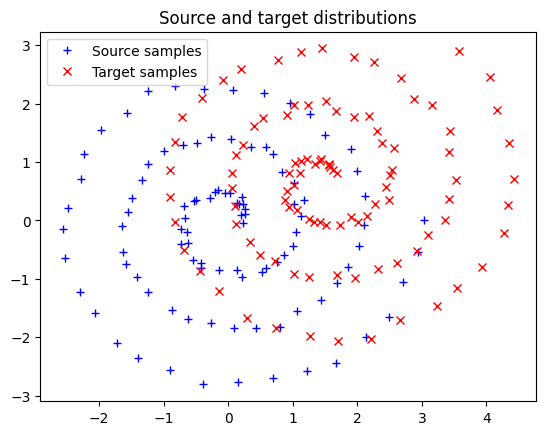

In [273]:
def spiral(t, a=0.2, b=0.15):
    # 간단한 나선 (r(t)=a + b t)
    r = a + b*t
    return np.stack([r*np.cos(t), r*np.sin(t)], axis=1)

n = 100
tX = np.linspace(0, 6*np.pi, n)             # 균일 시간
xs  = spiral(tX) + 0.05*np.random.randn(n,2)

# time-warping: 느리다가 빠르게 (모노톤 증가이지만 비균일)
# tau = np.linspace(0, 1, n)
# tw  = tau**1.8
# tY  = (tw*(tX[-1]-tX[0]) + tX[0])
# R   = np.array([[np.cos(0.5), -np.sin(0.5)],[np.sin(0.5), np.cos(0.5)]])
# shift= np.array([1.5, 0.7])
# xt  = (spiral(tY) @ R.T) + shift + 0.05*np.random.randn(n,2)

tau = np.linspace(0, 1, n)
tw  = tau**1
tY  = (tw*(tX[-1]-tX[0]) + tX[0])
shift= np.array([1.5, 0.7])
R   = np.array([[np.cos(0.8), -np.sin(0.8)],[np.sin(0.8), np.cos(0.8)]])
xt  = (spiral(tY) @ R.T) + shift + 0.05*np.random.randn(n,2)

# shift= np.array([1.5, 0.7])
# xt  = xs + shift #+ 0.05*np.random.randn(n,2)

plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples")
plt.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples")
plt.legend(loc=0)
plt.title("Source and target distributions")

In [286]:
model = FOT.ConvexFusedTransport(
    lam=3.0,
    h=0.3,
    kappa='decreasing_exp',
    metric='euclidean',
    fw_max_iter=200,
    fw_stepsize='classic',
    tol=1e-7,
    lmo_method='emd'
).fit(X=tX.reshape(-1,1),Y=tY.reshape(-1,1),FX=xs,FY=xt, return_hard_assignment=True)

In [287]:
# plt.plot(range(len(model.obj_history_)), model.obj_history_, marker='o')
# plt.xlabel('Iteration')
# plt.ylabel('Objective')
# plt.title('Objective per Iteration')
# plt.grid(True)
# plt.show()

In [288]:
# plt.plot(range(len(model.gap_history_)), model.gap_history_, marker='o')
# plt.xlabel('Iteration')
# plt.ylabel('FW Gap')
# plt.title('FW Gap per Iteration')
# plt.grid(True)
# plt.show()

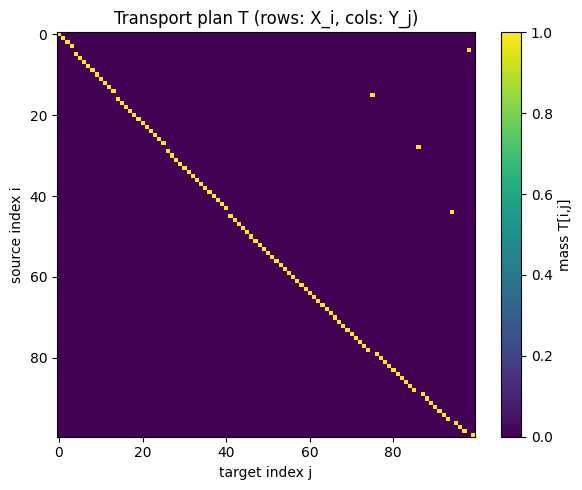

In [289]:
plot_transport_heatmap(model.P_)

In [166]:
M = ot.dist(xs,xt, metric='sqeuclidean')
C1 = ot.dist(tX.reshape(-1,1),tX.reshape(-1,1), metric='euclidean')
C2 = C1 = ot.dist(tY.reshape(-1,1),tY.reshape(-1,1), metric='euclidean')

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
alpha = 0.5
T_FGW = ot.gromov.fused_gromov_wasserstein(M, C1, C2, a, b, alpha=alpha, loss_fun='square_loss')

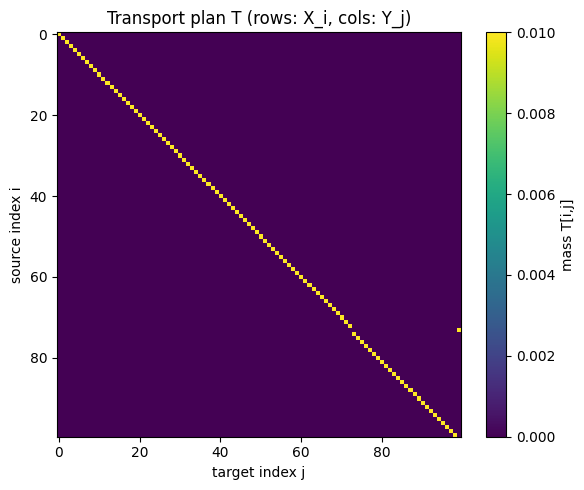

In [167]:
plot_transport_heatmap(T_FGW)

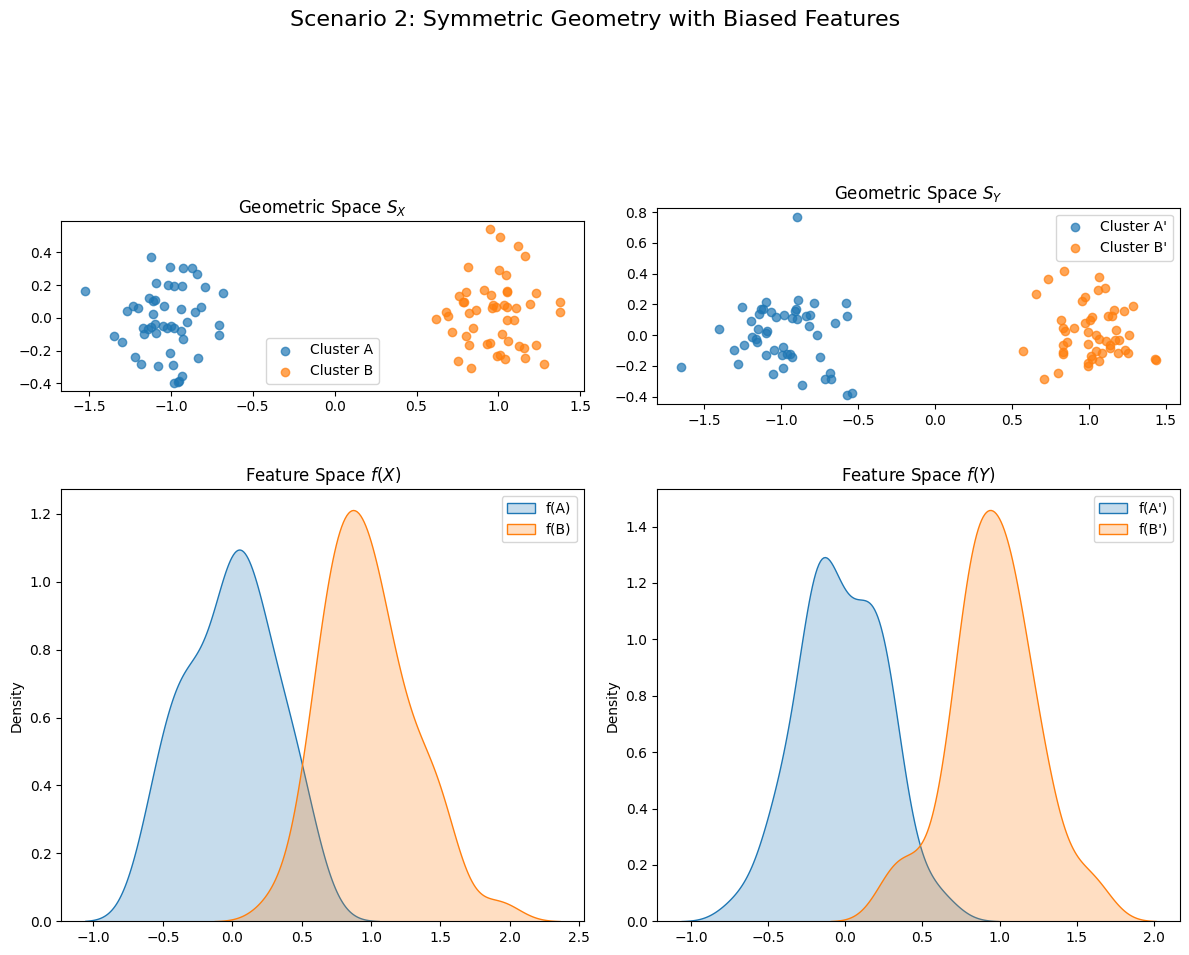

--- Cost Analysis (Approximate) ---
T1 (Correct: A->A', B->B') Feature Cost: 19.0701
T2 (Trap: A->B', B->A')    Feature Cost: 117.8328

Geometric GW cost for T1 and T2 are both near 0 due to symmetry.
T1 Total Cost (Global Min) approx: (1-a) * 19.0701 + a * (0)
T2 Total Cost (Local Min)  approx: (1-a) * 117.8328 + a * (0)

Success: T1 is the true global minimum, but T2 is a structurally plausible local minimum.


In [263]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns

def generate_data_scenario2(n_points_per_cluster=50, 
                            geom_center=2.0, 
                            geom_std=0.2, 
                            feature_std=0.3, 
                            epsilon=0.1):
    """
    시나리오 2: 대칭적 기하 구조와 비대칭적 Feature (국소 최적해 함정)
    
    - S_X, S_Y: (-c, 0)와 (+c, 0)에 위치한 두 개의 대칭적 군집 (A, B)와 (A', B').
    - f(X): f(A) ~ N(0, std^2), f(B) ~ N(1, std^2)
    - f(Y): f(A') ~ N(epsilon, std^2), f(B') ~ N(1-epsilon, std^2)
    
    이 설정은 두 개의 구조적 최적해를 만듭니다:
    1. T1 (정답): (A -> A', B -> B')
    2. T2 (함정): (A -> B', B -> A')
    
    T1의 Feature 비용은 ~2*epsilon^2 이고,
    T2의 Feature 비용은 ~2*(1-epsilon)^2 입니다.
    epsilon이 작으면 T1이 근소하게 우세하지만, T2도 매우 그럴듯한 국소 최적해가 됩니다.
    """
    
    # 1. S_X 기하 구조 생성
    X_A = np.random.normal(loc=[-geom_center, 0], scale=geom_std, size=(n_points_per_cluster, 2))
    X_B = np.random.normal(loc=[geom_center, 0], scale=geom_std, size=(n_points_per_cluster, 2))
    X = np.vstack((X_A, X_B))
    
    # 2. S_Y 기하 구조 생성 (X와 동일하여 대칭성 보장)
    Y_A = np.random.normal(loc=[-geom_center, 0], scale=geom_std, size=(n_points_per_cluster, 2))
    Y_B = np.random.normal(loc=[geom_center, 0], scale=geom_std, size=(n_points_per_cluster, 2))
    Y = np.vstack((Y_A, Y_B))
    
    # 3. f(X) Feature 생성 (1D)
    fX_A = np.random.normal(loc=0.0, scale=feature_std, size=(n_points_per_cluster, 1))
    fX_B = np.random.normal(loc=1.0, scale=feature_std, size=(n_points_per_cluster, 1))
    fX = np.vstack((fX_A, fX_B))
    
    # 4. f(Y) Feature 생성 (비대칭성 epsilon 도입)
    fY_A = np.random.normal(loc=0.0 + epsilon, scale=feature_std, size=(n_points_per_cluster, 1))
    fY_B = np.random.normal(loc=1.0 - epsilon, scale=feature_std, size=(n_points_per_cluster, 1))
    fY = np.vstack((fY_A, fY_B))
    
    # 레이블 생성 (시각화용)
    labels = np.array([0] * n_points_per_cluster + [1] * n_points_per_cluster)
    
    return X, Y, fX, fY, labels

def visualize_scenario2(X, Y, fX, fY, labels):
    """데이터셋 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    n = len(labels) // 2
    colors = ['#1f77b4', '#ff7f0e'] # Blue, Orange

    # 1. S_X 기하 구조
    axes[0, 0].scatter(X[:n, 0], X[:n, 1], c=colors[0], label='Cluster A', alpha=0.7)
    axes[0, 0].scatter(X[n:, 0], X[n:, 1], c=colors[1], label='Cluster B', alpha=0.7)
    axes[0, 0].set_title('Geometric Space $S_X$')
    axes[0, 0].set_aspect('equal', 'box')
    axes[0, 0].legend()

    # 2. S_Y 기하 구조
    axes[0, 1].scatter(Y[:n, 0], Y[:n, 1], c=colors[0], label="Cluster A'", alpha=0.7)
    axes[0, 1].scatter(Y[n:, 0], Y[n:, 1], c=colors[1], label="Cluster B'", alpha=0.7)
    axes[0, 1].set_title('Geometric Space $S_Y$')
    axes[0, 1].set_aspect('equal', 'box')
    axes[0, 1].legend()
    
    # 3. f(X) Feature 분포
    sns.kdeplot(fX[:n, 0], ax=axes[1, 0], color=colors[0], fill=True, label='f(A)')
    sns.kdeplot(fX[n:, 0], ax=axes[1, 0], color=colors[1], fill=True, label='f(B)')
    axes[1, 0].set_title('Feature Space $f(X)$')
    axes[1, 0].legend()

    # 4. f(Y) Feature 분포
    sns.kdeplot(fY[:n, 0], ax=axes[1, 1], color=colors[0], fill=True, label="f(A')")
    sns.kdeplot(fY[n:, 0], ax=axes[1, 1], color=colors[1], fill=True, label="f(B')")
    axes[1, 1].set_title('Feature Space $f(Y)$')
    axes[1, 1].legend()

    plt.suptitle('Scenario 2: Symmetric Geometry with Biased Features', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def analyze_costs(X, Y, fX, fY):
    """두 매핑 T1(정답)과 T2(함정)의 비용 분석"""
    n = len(X) // 2
    
    # Feature 비용 행렬 C_f
    C_f = cdist(fX, fY, 'sqeuclidean')
    
    # T1 (A->A', B->B')의 Feature 비용 (블록 대각합)
    # (참고: 실제 OT 비용은 아니지만, 매핑 비용의 근사치)
    cost_f_T1 = np.sum(np.diag(C_f[:n, :n])) + np.sum(np.diag(C_f[n:, n:]))
    
    # T2 (A->B', B->A')의 Feature 비용 (반대편 블록 대각합)
    cost_f_T2 = np.sum(np.diag(C_f[:n, n:])) + np.sum(np.diag(C_f[n:, :n]))
    
    print("--- Cost Analysis (Approximate) ---")
    print(f"T1 (Correct: A->A', B->B') Feature Cost: {cost_f_T1:.4f}")
    print(f"T2 (Trap: A->B', B->A')    Feature Cost: {cost_f_T2:.4f}")
    
    # 기하학적 비용은 시각적으로 동일함 (GW 비용이 둘 다 0에 가까움)
    print("\nGeometric GW cost for T1 and T2 are both near 0 due to symmetry.")
    print(f"T1 Total Cost (Global Min) approx: (1-a) * {cost_f_T1:.4f} + a * (0)")
    print(f"T2 Total Cost (Local Min)  approx: (1-a) * {cost_f_T2:.4f} + a * (0)")
    
    if cost_f_T1 < cost_f_T2:
        print("\nSuccess: T1 is the true global minimum, but T2 is a structurally plausible local minimum.")
    else:
        print("\nWarning: T2 cost is lower. Try increasing epsilon or n_points.")

# --- 메인 실행 ---
np.random.seed(42)

# Epsilon을 작게 설정하여 T1과 T2의 비용 차이를 근소하게 만듭니다.
EPSILON = 0.05 
N_POINTS = 50
GEOM_CENTER = 1.0

X, Y, fX, fY, labels = generate_data_scenario2(
    n_points_per_cluster=N_POINTS,
    geom_center=GEOM_CENTER,
    epsilon=EPSILON
)

visualize_scenario2(X, Y, fX, fY, labels)
analyze_costs(X, Y, fX, fY)

In [271]:
model = FOT.ConvexFusedTransport(
    lam=1.0,
    h=0.3,
    kappa='decreasing_exp',
    metric='euclidean',
    fw_max_iter=200,
    fw_stepsize='classic',
    tol=1e-7,
    lmo_method='emd'
).fit(X=X,Y=Y,FX=fX,FY=fY, return_hard_assignment=True)

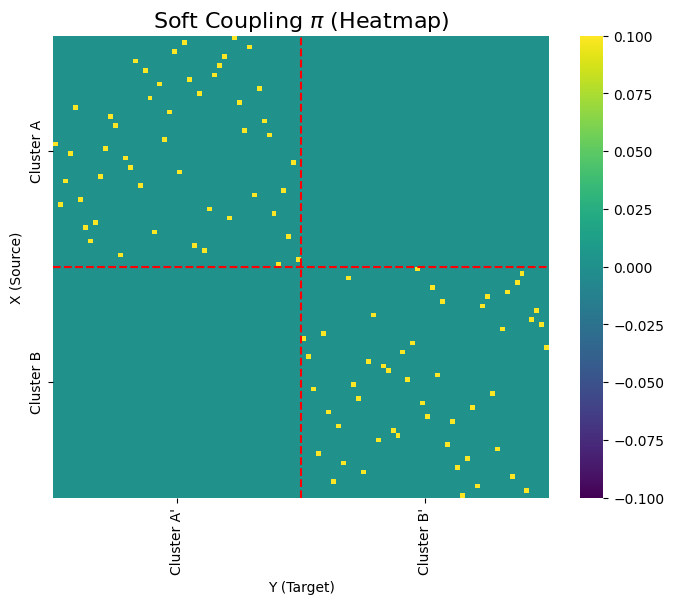

In [272]:
n = N_POINTS 

plt.figure(figsize=(8, 6))
sns.heatmap(model.P_, cmap='viridis', robust=True)

# 블록 구분을 위한 선
plt.axvline(n, color='red', linestyle='--')
plt.axhline(n, color='red', linestyle='--')

plt.title('Soft Coupling $\\pi$ (Heatmap)', fontsize=16)
plt.xlabel('Y (Target)')
plt.ylabel('X (Source)')
plt.xticks([n/2, n + n/2], ["Cluster A'", "Cluster B'"])
plt.yticks([n/2, n + n/2], ["Cluster A", "Cluster B"])
plt.show()

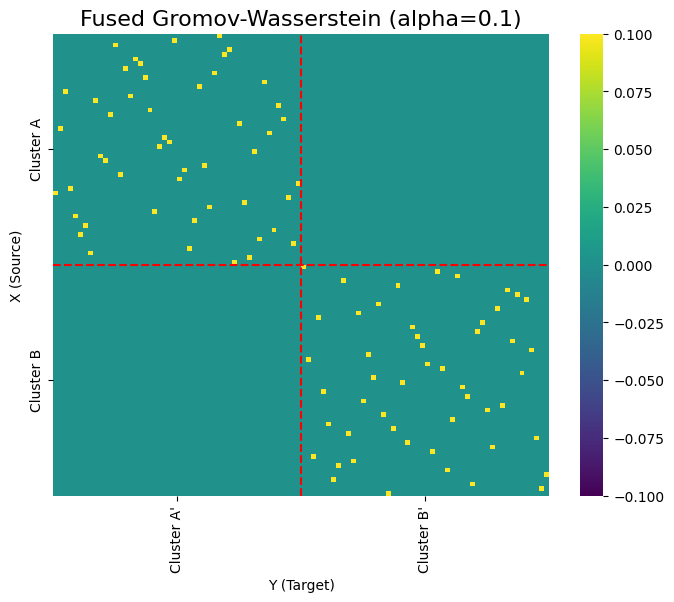

In [270]:
# --- 1. 변수 설정 (명확하게 분리) ---
n_cluster = N_POINTS     # 50
n_total = N_POINTS * 2   # 100

# Feature 비용 (OT 비용)
M = ot.dist(fX, fY, metric='sqeuclidean')/float(M.max())

# 구조 비용 (GW 비용)
# C1을 X로부터 계산
C1 = ot.dist(X, X, metric='euclidean')/float(C1.max())
# C2를 Y로부터 계산 (C1을 덮어쓰지 않도록 수정)
C2 = ot.dist(Y, Y, metric='euclidean')/float(C2.max())

# 균일 분포
a = np.ones((n_total,)) / n_total
b = np.ones((n_total,)) / n_total

alpha = 0.1 # GW(구조)와 OT(Feature)의 비중

# --- 2. FGW 계산 ---
# 초기값을 주지 않으면 FGW 솔버가 임의로 시작합니다.
# 이것이 바로 "국소 최적해" 함정을 테스트하는 핵심입니다.
T_FGW = ot.gromov.fused_gromov_wasserstein(M, C1, C2, a, b, alpha=alpha, loss_fun='square_loss')

# --- 3. 플로팅 ---
plt.figure(figsize=(8, 6))
# T_FGW는 n_total x n_total (100x100) 행렬입니다.
sns.heatmap(T_FGW/float(T_FGW.max()), cmap='viridis', robust=True)

# 블록 구분을 위한 선 (n_cluster = 50)
plt.axvline(n_cluster, color='red', linestyle='--')
plt.axhline(n_cluster, color='red', linestyle='--')

plt.title(f'Fused Gromov-Wasserstein (alpha={alpha})', fontsize=16)
plt.xlabel('Y (Target)')
plt.ylabel('X (Source)')
# Ticks (n_cluster = 50 기준)
plt.xticks([n_cluster/2, n_cluster + n_cluster/2], ["Cluster A'", "Cluster B'"])
plt.yticks([n_cluster/2, n_cluster + n_cluster/2], ["Cluster A", "Cluster B"])
plt.show()